In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 3
num_attr_vals = 3
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 27 unqiue cards
Generated 351 cardpairs
-- 243 cardpairs with shared concept
-- 108 cardpairs without shared concept
[(1, 162), (0, 108), (2, 81)]
Total number of matches =  2673
Number of shared concepts per match =  [(1, 2430), (2, 243)]


## Data -- Distribution, Splits

In [3]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1.0000000000000003e-100, 6804), (0.0003741114852225964, 2673)]

In [5]:
np.sum(count_table)

2673.0

In [6]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 19
xy_div_xyind_rank= 19


In [7]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

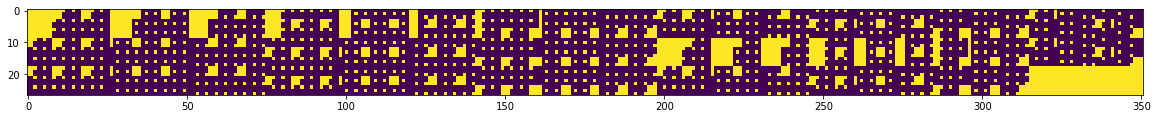

In [8]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

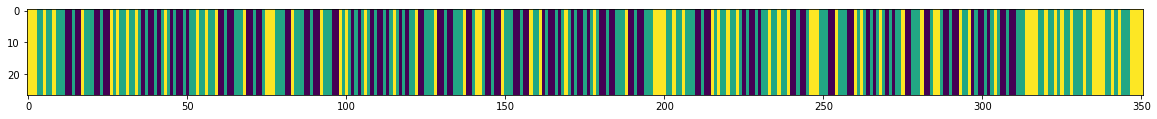

In [9]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

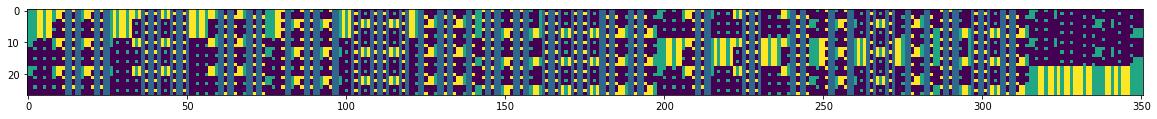

In [10]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

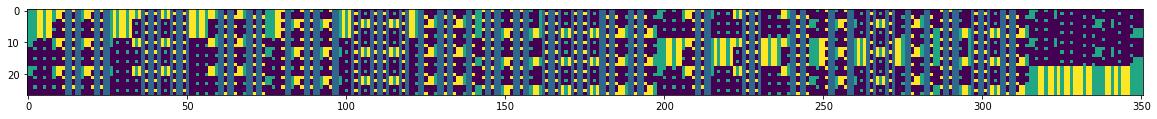

In [11]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [12]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(0.9999999999999992, 2268),
 (8.018999999999998e-97, 2268),
 (2.999999999999999, 1134),
 (1.7999999999999994, 945),
 (4.811399999999998e-97, 756),
 (8.018999999999995e-97, 432),
 (0.9999999999999989, 432),
 (2.999999999999998, 216),
 (8.018999999999996e-97, 216),
 (0.9999999999999991, 216),
 (1.7999999999999987, 180),
 (4.811399999999996e-97, 144),
 (2.9999999999999987, 108),
 (1.7999999999999992, 90),
 (4.811399999999997e-97, 72)]

## Dataset

In [13]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square') ('green', 'void', 'triangle')
key
 0 ('red', 'void', 'square')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('green', 'void', 'square'), ('green', 'void', 'circle'), ('green', 'void', 'triangle'), ('blue', 'void', 'square'), ('blue', 'void', 'circle'), ('blue', 'void', 'triangle')]
-----
query
 7 : 0 8 ('red', 'void', 'square') ('red', 'solid', 'triangle')
key
 0 ('red', 'void', 'square')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'dashed', 'square'), ('red', 'dashed', 'circle'), ('red', 'dashed', 'triangle'), ('red', 'solid', 'square'), ('red', 'solid', 'circle'), ('red', 'solid', 'triangle')]


(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]))

In [14]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square') ('green', 'void', 'triangle')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('green', 'void', 'square'), ('green', 'void', 'circle'), ('green', 'void', 'triangle'), ('blue', 'void', 'square'), ('blue', 'void', 'circle'), ('blue', 'void', 'triangle')]
-----
query
 7 : 0 8 ('red', 'void', 'square') ('red', 'solid', 'triangle')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'dashed', 'square'), ('red', 'dashed', 'circle'), ('red', 'dashed', 'triangle'), ('red', 'solid', 'square'), ('red', 'solid', 'circle'), ('red', 'solid', 'triangle')]


(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]))

In [15]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [16]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [17]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [18]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            raise ValueError('Not supposed to use classifier!')
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [19]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [20]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [21]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [22]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 32,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':True,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K;dot-product'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 12.1 K
1  | model.inp_query_layer                        | Sequential         | 11.2 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 11.2 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 11.2 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 864   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 864   
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 864   
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## Run Training

In [23]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=5000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory checkpoints/ContrastiveLearning-cardgame-Scaling/CardGame:OR;attr3-val3;epsilon1e-100;d_model32;params12.1K;dot-product exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-23-5a38702b0d8c>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():



   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 12.1 K
1  | model.inp_query_layer                        | Sequential         | 11.2 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 11.2 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 11.2 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 864   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 864   
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 864   
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                     

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 15.92it/s, loss=776, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 15.68it/s, loss=776, v_num=x10n]
                                                 

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 1:  50%|█████     | 1/2 [00:00<00:00, 14.08it/s, loss=767, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00, 18.96it/s, loss=777, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00, 17.79it/s, loss=776, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00, 19.07it/s, loss=779, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00, 19.12it/s, loss=780, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=777, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00, 19.30it/s, loss=776, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=777, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=774, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 10:  50%|█████     | 1

Epoch 44:  50%|█████     | 1/2 [00:00<00:00, 16.87it/s, loss=719, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|█████     | 1/2 [00:00<00:00, 17.41it/s, loss=717, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 46:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=715, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 47:  50%|█████     | 1/2 [00:00<00:00, 17.84it/s, loss=714, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 48:  50%|█████     | 1/2 [00:00<00:00, 17.99it/s, loss=713, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.75it/s, loss=710, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 50:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=711, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 51:  50%|█████     | 1/2 [00:00<00:00, 16.97it/s, loss=710, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 52:  50%|█████     | 1/2 [00:00<00:00, 17.77it/s, loss=710, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 53:  50%|████

Epoch 87:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s, loss=668, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 88:  50%|█████     | 1/2 [00:00<00:00, 19.39it/s, loss=667, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 89:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=666, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 90:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=664, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 91:  50%|█████     | 1/2 [00:00<00:00, 17.93it/s, loss=663, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 92:  50%|█████     | 1/2 [00:00<00:00, 17.95it/s, loss=662, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 93:  50%|█████     | 1/2 [00:00<00:00, 17.52it/s, loss=661, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 94:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=660, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 95:  50%|█████     | 1/2 [00:00<00:00, 17.55it/s, loss=658, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 96:  50%|████

Epoch 130:  50%|█████     | 1/2 [00:00<00:00, 15.46it/s, loss=634, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 131:  50%|█████     | 1/2 [00:00<00:00, 17.50it/s, loss=632, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 132:  50%|█████     | 1/2 [00:00<00:00, 18.00it/s, loss=632, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 133:  50%|█████     | 1/2 [00:00<00:00, 16.97it/s, loss=631, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 134:  50%|█████     | 1/2 [00:00<00:00, 16.45it/s, loss=632, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 135:  50%|█████     | 1/2 [00:00<00:00, 13.19it/s, loss=631, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 136:  50%|█████     | 1/2 [00:00<00:00, 17.00it/s, loss=629, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 137:  50%|█████     | 1/2 [00:00<00:00, 17.12it/s, loss=628, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 138:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=629, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 139:

Epoch 172:  50%|█████     | 1/2 [00:00<00:00, 17.89it/s, loss=611, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 173:  50%|█████     | 1/2 [00:00<00:00, 17.79it/s, loss=611, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 174:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=610, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 175:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=608, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 176:  50%|█████     | 1/2 [00:00<00:00, 18.32it/s, loss=607, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 177:  50%|█████     | 1/2 [00:00<00:00, 17.38it/s, loss=605, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 178:  50%|█████     | 1/2 [00:00<00:00, 16.12it/s, loss=605, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 179:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=605, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 180:  50%|█████     | 1/2 [00:00<00:00, 18.80it/s, loss=604, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 181:

Epoch 215:  50%|█████     | 1/2 [00:00<00:00, 17.46it/s, loss=592, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 216:  50%|█████     | 1/2 [00:00<00:00, 16.99it/s, loss=592, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 217:  50%|█████     | 1/2 [00:00<00:00, 15.15it/s, loss=592, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 218:  50%|█████     | 1/2 [00:00<00:00, 15.77it/s, loss=592, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 219:  50%|█████     | 1/2 [00:00<00:00, 17.64it/s, loss=593, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 220:  50%|█████     | 1/2 [00:00<00:00, 14.30it/s, loss=594, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 221:  50%|█████     | 1/2 [00:00<00:00, 17.86it/s, loss=592, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 222:  50%|█████     | 1/2 [00:00<00:00, 15.97it/s, loss=593, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 223:  50%|█████     | 1/2 [00:00<00:00, 15.65it/s, loss=592, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 224:

Epoch 257:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=581, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 258:  50%|█████     | 1/2 [00:00<00:00, 16.08it/s, loss=581, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 259:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=581, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 260:  50%|█████     | 1/2 [00:00<00:00, 16.96it/s, loss=581, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 261:  50%|█████     | 1/2 [00:00<00:00, 19.04it/s, loss=581, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 262:  50%|█████     | 1/2 [00:00<00:00, 17.55it/s, loss=579, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 263:  50%|█████     | 1/2 [00:00<00:00, 18.18it/s, loss=578, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 264:  50%|█████     | 1/2 [00:00<00:00, 13.38it/s, loss=577, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 265:  50%|█████     | 1/2 [00:00<00:00, 16.16it/s, loss=577, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 266:

Epoch 300:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=566, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 301:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=566, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 302:  50%|█████     | 1/2 [00:00<00:00, 13.64it/s, loss=565, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 303:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=565, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 304:  50%|█████     | 1/2 [00:00<00:00, 16.97it/s, loss=565, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 305:  50%|█████     | 1/2 [00:00<00:00, 17.14it/s, loss=565, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 306:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=565, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 307:  50%|█████     | 1/2 [00:00<00:00, 13.22it/s, loss=564, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 308:  50%|█████     | 1/2 [00:00<00:00, 17.79it/s, loss=564, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 309:

Epoch 342:  50%|█████     | 1/2 [00:00<00:00, 17.48it/s, loss=559, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 343:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=559, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 344:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=559, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 345:  50%|█████     | 1/2 [00:00<00:00, 13.74it/s, loss=559, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 346:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=559, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 347:  50%|█████     | 1/2 [00:00<00:00, 13.85it/s, loss=559, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 348:  50%|█████     | 1/2 [00:00<00:00, 14.99it/s, loss=559, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 349: 100%|██████████| 2/2 [00:00<00:00, 12.11it/s, loss=559, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 350:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=559, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 351:

Epoch 385:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=552, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 386:  50%|█████     | 1/2 [00:00<00:00, 14.30it/s, loss=553, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 387:  50%|█████     | 1/2 [00:00<00:00, 18.34it/s, loss=553, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 388:  50%|█████     | 1/2 [00:00<00:00, 16.72it/s, loss=552, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 389:  50%|█████     | 1/2 [00:00<00:00, 17.25it/s, loss=553, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 390:  50%|█████     | 1/2 [00:00<00:00, 16.85it/s, loss=553, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 391:  50%|█████     | 1/2 [00:00<00:00, 18.39it/s, loss=553, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 392:  50%|█████     | 1/2 [00:00<00:00, 17.57it/s, loss=553, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 393:  50%|█████     | 1/2 [00:00<00:00, 13.63it/s, loss=552, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 394:

Epoch 427:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=548, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 428:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=548, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 429:  50%|█████     | 1/2 [00:00<00:00, 12.76it/s, loss=548, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 430:  50%|█████     | 1/2 [00:00<00:00, 13.19it/s, loss=547, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 431:  50%|█████     | 1/2 [00:00<00:00, 16.01it/s, loss=547, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 432:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=547, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 433:  50%|█████     | 1/2 [00:00<00:00, 17.06it/s, loss=548, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 434:  50%|█████     | 1/2 [00:00<00:00, 17.54it/s, loss=548, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 435:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=548, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 436:

Epoch 470:  50%|█████     | 1/2 [00:00<00:00, 15.22it/s, loss=544, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 471:  50%|█████     | 1/2 [00:00<00:00, 15.65it/s, loss=544, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 472:  50%|█████     | 1/2 [00:00<00:00, 16.63it/s, loss=544, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 473:  50%|█████     | 1/2 [00:00<00:00, 17.40it/s, loss=544, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 474:  50%|█████     | 1/2 [00:00<00:00, 15.46it/s, loss=543, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 475:  50%|█████     | 1/2 [00:00<00:00, 17.40it/s, loss=544, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 476:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=543, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 477:  50%|█████     | 1/2 [00:00<00:00, 18.12it/s, loss=543, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 478:  50%|█████     | 1/2 [00:00<00:00, 15.65it/s, loss=544, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 479:

Epoch 512:  50%|█████     | 1/2 [00:00<00:00, 18.36it/s, loss=538, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 513:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=539, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 514:  50%|█████     | 1/2 [00:00<00:00, 13.95it/s, loss=539, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 515:  50%|█████     | 1/2 [00:00<00:00, 17.93it/s, loss=539, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 516:  50%|█████     | 1/2 [00:00<00:00, 12.90it/s, loss=540, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 517:  50%|█████     | 1/2 [00:00<00:00, 18.80it/s, loss=539, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 518:  50%|█████     | 1/2 [00:00<00:00, 16.90it/s, loss=539, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 519:  50%|█████     | 1/2 [00:00<00:00, 17.42it/s, loss=540, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 520:  50%|█████     | 1/2 [00:00<00:00, 14.67it/s, loss=541, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 521:

Epoch 555:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=538, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 556:  50%|█████     | 1/2 [00:00<00:00, 17.20it/s, loss=538, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 557:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=538, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 558:  50%|█████     | 1/2 [00:00<00:00, 12.87it/s, loss=538, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 559:  50%|█████     | 1/2 [00:00<00:00, 12.84it/s, loss=538, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 560:  50%|█████     | 1/2 [00:00<00:00, 18.41it/s, loss=538, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 561:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=538, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 562:  50%|█████     | 1/2 [00:00<00:00, 16.83it/s, loss=537, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 563:  50%|█████     | 1/2 [00:00<00:00, 17.43it/s, loss=537, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 564:

Epoch 597:  50%|█████     | 1/2 [00:00<00:00, 15.56it/s, loss=536, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 598:  50%|█████     | 1/2 [00:00<00:00, 18.87it/s, loss=535, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 599: 100%|██████████| 2/2 [00:00<00:00, 13.20it/s, loss=536, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 600:  50%|█████     | 1/2 [00:00<00:00, 17.54it/s, loss=536, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 601:  50%|█████     | 1/2 [00:00<00:00, 17.52it/s, loss=536, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 602:  50%|█████     | 1/2 [00:00<00:00, 13.39it/s, loss=536, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 603:  50%|█████     | 1/2 [00:00<00:00, 16.28it/s, loss=536, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 604:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=536, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 605:  50%|█████     | 1/2 [00:00<00:00, 14.91it/s, loss=537, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 606:

Epoch 640:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=532, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 641:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 642:  50%|█████     | 1/2 [00:00<00:00, 18.37it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 643:  50%|█████     | 1/2 [00:00<00:00, 18.84it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 644:  50%|█████     | 1/2 [00:00<00:00, 16.19it/s, loss=532, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 645:  50%|█████     | 1/2 [00:00<00:00, 18.37it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 646:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=532, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 647:  50%|█████     | 1/2 [00:00<00:00, 16.40it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 648:  50%|█████     | 1/2 [00:00<00:00, 17.43it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 649:

Epoch 682:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 683:  50%|█████     | 1/2 [00:00<00:00, 16.67it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 684:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=534, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 685:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=534, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 686:  50%|█████     | 1/2 [00:00<00:00, 18.41it/s, loss=535, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 687:  50%|█████     | 1/2 [00:00<00:00, 17.15it/s, loss=535, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 688:  50%|█████     | 1/2 [00:00<00:00, 18.99it/s, loss=535, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 689:  50%|█████     | 1/2 [00:00<00:00, 16.84it/s, loss=535, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 690:  50%|█████     | 1/2 [00:00<00:00, 17.73it/s, loss=535, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 691:

Epoch 725:  50%|█████     | 1/2 [00:00<00:00, 17.18it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 726:  50%|█████     | 1/2 [00:00<00:00, 15.67it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 727:  50%|█████     | 1/2 [00:00<00:00, 18.82it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 728:  50%|█████     | 1/2 [00:00<00:00, 17.94it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 729:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=534, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 730:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=534, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 731:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=534, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 732:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 733:  50%|█████     | 1/2 [00:00<00:00, 19.10it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 734:

Epoch 767:  50%|█████     | 1/2 [00:00<00:00, 17.81it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 768:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 769:  50%|█████     | 1/2 [00:00<00:00, 13.80it/s, loss=532, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 770:  50%|█████     | 1/2 [00:00<00:00, 17.02it/s, loss=532, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 771:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=531, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 772:  50%|█████     | 1/2 [00:00<00:00, 16.04it/s, loss=532, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 773:  50%|█████     | 1/2 [00:00<00:00, 12.77it/s, loss=532, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 774:  50%|█████     | 1/2 [00:00<00:00, 16.27it/s, loss=531, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 775:  50%|█████     | 1/2 [00:00<00:00, 18.34it/s, loss=531, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 776:

Epoch 810:  50%|█████     | 1/2 [00:00<00:00, 13.80it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 811:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 812:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=533, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 813:  50%|█████     | 1/2 [00:00<00:00, 16.93it/s, loss=532, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 814:  50%|█████     | 1/2 [00:00<00:00, 13.57it/s, loss=532, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 815:  50%|█████     | 1/2 [00:00<00:00, 16.35it/s, loss=531, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 816:  50%|█████     | 1/2 [00:00<00:00, 15.43it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 817:  50%|█████     | 1/2 [00:00<00:00, 15.93it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 818:  50%|█████     | 1/2 [00:00<00:00, 15.93it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 819:

Epoch 852:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=531, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 853:  50%|█████     | 1/2 [00:00<00:00, 18.08it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 854:  50%|█████     | 1/2 [00:00<00:00, 16.23it/s, loss=531, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 855:  50%|█████     | 1/2 [00:00<00:00, 16.99it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 856:  50%|█████     | 1/2 [00:00<00:00, 17.29it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 857:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 858:  50%|█████     | 1/2 [00:00<00:00, 13.13it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 859:  50%|█████     | 1/2 [00:00<00:00, 13.69it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 860:  50%|█████     | 1/2 [00:00<00:00, 18.41it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 861:

Epoch 895:  50%|█████     | 1/2 [00:00<00:00, 15.86it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 896:  50%|█████     | 1/2 [00:00<00:00, 15.83it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 897:  50%|█████     | 1/2 [00:00<00:00, 13.51it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 898:  50%|█████     | 1/2 [00:00<00:00, 17.84it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 899: 100%|██████████| 2/2 [00:00<00:00, 11.70it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 900:  50%|█████     | 1/2 [00:00<00:00, 17.33it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 901:  50%|█████     | 1/2 [00:00<00:00, 18.27it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 902:  50%|█████     | 1/2 [00:00<00:00, 15.72it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 903:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=529, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 904:

Epoch 937:  50%|█████     | 1/2 [00:00<00:00, 17.77it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 938:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 939:  50%|█████     | 1/2 [00:00<00:00, 16.43it/s, loss=529, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 940:  50%|█████     | 1/2 [00:00<00:00, 17.20it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 942:  50%|█████     | 1/2 [00:00<00:00, 18.66it/s, loss=529, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 943:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=529, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 944:  50%|█████     | 1/2 [00:00<00:00, 16.69it/s, loss=529, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 945:  50%|█████     | 1/2 [00:00<00:00, 17.76it/s, loss=529, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 946:

Epoch 980:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 981:  50%|█████     | 1/2 [00:00<00:00, 16.16it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 982:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 983:  50%|█████     | 1/2 [00:00<00:00, 13.10it/s, loss=529, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 984:  50%|█████     | 1/2 [00:00<00:00, 17.50it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 985:  50%|█████     | 1/2 [00:00<00:00, 15.84it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 986:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=531, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 987:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 988:  50%|█████     | 1/2 [00:00<00:00, 17.37it/s, loss=530, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 989:

Epoch 1022:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=529, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1023:  50%|█████     | 1/2 [00:00<00:00, 13.95it/s, loss=529, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1024:  50%|█████     | 1/2 [00:00<00:00, 15.57it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1025:  50%|█████     | 1/2 [00:00<00:00, 16.91it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1026:  50%|█████     | 1/2 [00:00<00:00, 16.73it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1027:  50%|█████     | 1/2 [00:00<00:00, 16.98it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1028:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1029:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1030:  50%|█████     | 1/2 [00:00<00:00, 17.21it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1064:  50%|█████     | 1/2 [00:00<00:00, 17.36it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1065:  50%|█████     | 1/2 [00:00<00:00, 14.55it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1066:  50%|█████     | 1/2 [00:00<00:00, 16.47it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1067:  50%|█████     | 1/2 [00:00<00:00, 18.52it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1068:  50%|█████     | 1/2 [00:00<00:00, 17.77it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1069:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1070:  50%|█████     | 1/2 [00:00<00:00, 16.25it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1071:  50%|█████     | 1/2 [00:00<00:00, 17.19it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1072:  50%|█████     | 1/2 [00:00<00:00, 17.10it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1106:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1107:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1108:  50%|█████     | 1/2 [00:00<00:00, 20.45it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1109:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1110:  50%|█████     | 1/2 [00:00<00:00, 17.56it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1111:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1112:  50%|█████     | 1/2 [00:00<00:00, 18.42it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1113:  50%|█████     | 1/2 [00:00<00:00, 17.88it/s, loss=528, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1114:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1148:  50%|█████     | 1/2 [00:00<00:00, 17.83it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1149: 100%|██████████| 2/2 [00:00<00:00, 10.73it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1150:  50%|█████     | 1/2 [00:00<00:00, 14.51it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1151:  50%|█████     | 1/2 [00:00<00:00, 17.18it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1152:  50%|█████     | 1/2 [00:00<00:00, 18.93it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1153:  50%|█████     | 1/2 [00:00<00:00, 18.62it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1154:  50%|█████     | 1/2 [00:00<00:00, 13.41it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1155:  50%|█████     | 1/2 [00:00<00:00, 16.20it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1156:  50%|█████     | 1/2 [00:00<00:00, 17.45it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1190:  50%|█████     | 1/2 [00:00<00:00, 14.74it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1191:  50%|█████     | 1/2 [00:00<00:00, 16.99it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1192:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=525, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1193:  50%|█████     | 1/2 [00:00<00:00, 16.84it/s, loss=525, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1194:  50%|█████     | 1/2 [00:00<00:00, 18.05it/s, loss=525, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1195:  50%|█████     | 1/2 [00:00<00:00, 18.84it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1196:  50%|█████     | 1/2 [00:00<00:00, 17.61it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1197:  50%|█████     | 1/2 [00:00<00:00, 13.85it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1198:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=525, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1232:  50%|█████     | 1/2 [00:00<00:00, 17.25it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1233:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1234:  50%|█████     | 1/2 [00:00<00:00, 17.19it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1235:  50%|█████     | 1/2 [00:00<00:00, 17.70it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1236:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1237:  50%|█████     | 1/2 [00:00<00:00, 18.27it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1238:  50%|█████     | 1/2 [00:00<00:00, 15.40it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1239:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1240:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1274:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1275:  50%|█████     | 1/2 [00:00<00:00, 18.04it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1276:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1277:  50%|█████     | 1/2 [00:00<00:00, 17.83it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1278:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1279:  50%|█████     | 1/2 [00:00<00:00, 17.36it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1280:  50%|█████     | 1/2 [00:00<00:00, 16.60it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1281:  50%|█████     | 1/2 [00:00<00:00, 17.80it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1282:  50%|█████     | 1/2 [00:00<00:00, 17.57it/s, loss=527, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1316:  50%|█████     | 1/2 [00:00<00:00, 15.57it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1317:  50%|█████     | 1/2 [00:00<00:00, 15.72it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1318:  50%|█████     | 1/2 [00:00<00:00, 17.10it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1319:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1320:  50%|█████     | 1/2 [00:00<00:00, 15.32it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1321:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1322:  50%|█████     | 1/2 [00:00<00:00, 14.75it/s, loss=526, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1323:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=525, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1324:  50%|█████     | 1/2 [00:00<00:00, 18.43it/s, loss=525, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1358:  50%|█████     | 1/2 [00:00<00:00, 16.90it/s, loss=525, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1359:  50%|█████     | 1/2 [00:00<00:00, 13.78it/s, loss=525, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1360:  50%|█████     | 1/2 [00:00<00:00, 13.21it/s, loss=525, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1361:  50%|█████     | 1/2 [00:00<00:00, 12.71it/s, loss=525, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1362:  50%|█████     | 1/2 [00:00<00:00, 12.09it/s, loss=525, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1363:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=525, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1364:  50%|█████     | 1/2 [00:00<00:00, 16.91it/s, loss=525, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1365:  50%|█████     | 1/2 [00:00<00:00, 16.67it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1366:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1400:  50%|█████     | 1/2 [00:00<00:00, 17.18it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1401:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1402:  50%|█████     | 1/2 [00:00<00:00, 16.55it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1403:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1404:  50%|█████     | 1/2 [00:00<00:00, 15.93it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1405:  50%|█████     | 1/2 [00:00<00:00, 16.92it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1406:  50%|█████     | 1/2 [00:00<00:00, 17.42it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1407:  50%|█████     | 1/2 [00:00<00:00, 16.19it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1408:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1442:  50%|█████     | 1/2 [00:00<00:00, 14.07it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1443:  50%|█████     | 1/2 [00:00<00:00, 16.38it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1444:  50%|█████     | 1/2 [00:00<00:00, 17.21it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1445:  50%|█████     | 1/2 [00:00<00:00, 16.88it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1446:  50%|█████     | 1/2 [00:00<00:00, 13.36it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1447:  50%|█████     | 1/2 [00:00<00:00, 16.91it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1448:  50%|█████     | 1/2 [00:00<00:00, 18.24it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1449: 100%|██████████| 2/2 [00:00<00:00, 13.19it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1450:  50%|█████     | 1/2 [00:00<00:00, 17.36it/s, loss=524, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1484:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1485:  50%|█████     | 1/2 [00:00<00:00, 15.58it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1486:  50%|█████     | 1/2 [00:00<00:00, 16.67it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1487:  50%|█████     | 1/2 [00:00<00:00, 14.02it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1488:  50%|█████     | 1/2 [00:00<00:00, 15.13it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1489:  50%|█████     | 1/2 [00:00<00:00, 15.88it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1490:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1491:  50%|█████     | 1/2 [00:00<00:00, 18.02it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1492:  50%|█████     | 1/2 [00:00<00:00, 15.10it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1526:  50%|█████     | 1/2 [00:00<00:00, 15.49it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1527:  50%|█████     | 1/2 [00:00<00:00, 14.19it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1528:  50%|█████     | 1/2 [00:00<00:00, 18.22it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1529:  50%|█████     | 1/2 [00:00<00:00, 18.25it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1530:  50%|█████     | 1/2 [00:00<00:00, 16.86it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1531:  50%|█████     | 1/2 [00:00<00:00, 16.54it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1532:  50%|█████     | 1/2 [00:00<00:00, 12.44it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1533:  50%|█████     | 1/2 [00:00<00:00, 16.70it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1534:  50%|█████     | 1/2 [00:00<00:00, 17.49it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1568:  50%|█████     | 1/2 [00:00<00:00, 12.43it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1569:  50%|█████     | 1/2 [00:00<00:00, 17.39it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1570:  50%|█████     | 1/2 [00:00<00:00, 17.94it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1571:  50%|█████     | 1/2 [00:00<00:00, 16.52it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1572:  50%|█████     | 1/2 [00:00<00:00, 13.94it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1573:  50%|█████     | 1/2 [00:00<00:00, 17.05it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1574:  50%|█████     | 1/2 [00:00<00:00, 17.72it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1575:  50%|█████     | 1/2 [00:00<00:00, 20.67it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1576:  50%|█████     | 1/2 [00:00<00:00, 16.12it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1610:  50%|█████     | 1/2 [00:00<00:00, 16.74it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1611:  50%|█████     | 1/2 [00:00<00:00, 17.20it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1612:  50%|█████     | 1/2 [00:00<00:00, 15.88it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1613:  50%|█████     | 1/2 [00:00<00:00, 15.40it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1614:  50%|█████     | 1/2 [00:00<00:00, 16.75it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1615:  50%|█████     | 1/2 [00:00<00:00, 16.15it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1616:  50%|█████     | 1/2 [00:00<00:00, 18.86it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1617:  50%|█████     | 1/2 [00:00<00:00, 16.64it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1618:  50%|█████     | 1/2 [00:00<00:00, 16.87it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1652:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1653:  50%|█████     | 1/2 [00:00<00:00, 16.89it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1654:  50%|█████     | 1/2 [00:00<00:00, 17.55it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1655:  50%|█████     | 1/2 [00:00<00:00, 17.87it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1656:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1657:  50%|█████     | 1/2 [00:00<00:00, 13.78it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1658:  50%|█████     | 1/2 [00:00<00:00, 14.07it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1659:  50%|█████     | 1/2 [00:00<00:00, 13.74it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1660:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1694:  50%|█████     | 1/2 [00:00<00:00, 17.06it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1695:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1696:  50%|█████     | 1/2 [00:00<00:00, 16.62it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1697:  50%|█████     | 1/2 [00:00<00:00, 15.64it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1698:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1699: 100%|██████████| 2/2 [00:00<00:00, 12.12it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1700:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1701:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=523, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1702:  50%|█████     | 1/2 [00:00<00:00, 16.14it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1736:  50%|█████     | 1/2 [00:00<00:00, 12.54it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1737:  50%|█████     | 1/2 [00:00<00:00, 18.47it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1738:  50%|█████     | 1/2 [00:00<00:00, 13.97it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1739:  50%|█████     | 1/2 [00:00<00:00, 17.35it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1740:  50%|█████     | 1/2 [00:00<00:00, 12.82it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1741:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1742:  50%|█████     | 1/2 [00:00<00:00, 18.04it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1743:  50%|█████     | 1/2 [00:00<00:00, 13.15it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1744:  50%|█████     | 1/2 [00:00<00:00, 16.07it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1778:  50%|█████     | 1/2 [00:00<00:00, 15.64it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1779:  50%|█████     | 1/2 [00:00<00:00, 17.41it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1780:  50%|█████     | 1/2 [00:00<00:00, 15.26it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1781:  50%|█████     | 1/2 [00:00<00:00, 16.44it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1782:  50%|█████     | 1/2 [00:00<00:00, 17.73it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1783:  50%|█████     | 1/2 [00:00<00:00, 17.15it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1784:  50%|█████     | 1/2 [00:00<00:00, 12.45it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1785:  50%|█████     | 1/2 [00:00<00:00, 13.55it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1786:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1820:  50%|█████     | 1/2 [00:00<00:00, 17.28it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1821:  50%|█████     | 1/2 [00:00<00:00, 16.78it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1822:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1823:  50%|█████     | 1/2 [00:00<00:00, 16.67it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1824:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1825:  50%|█████     | 1/2 [00:00<00:00, 16.21it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1826:  50%|█████     | 1/2 [00:00<00:00, 13.46it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1827:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1828:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1862:  50%|█████     | 1/2 [00:00<00:00, 17.30it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1863:  50%|█████     | 1/2 [00:00<00:00, 16.74it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1864:  50%|█████     | 1/2 [00:00<00:00, 13.74it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1865:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|█████     | 1/2 [00:00<00:00, 15.81it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|█████     | 1/2 [00:00<00:00, 16.42it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1868:  50%|█████     | 1/2 [00:00<00:00, 13.26it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1869:  50%|█████     | 1/2 [00:00<00:00, 15.80it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1870:  50%|█████     | 1/2 [00:00<00:00, 13.63it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1904:  50%|█████     | 1/2 [00:00<00:00, 15.99it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1905:  50%|█████     | 1/2 [00:00<00:00, 15.35it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1906:  50%|█████     | 1/2 [00:00<00:00, 13.20it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1907:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1908:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1909:  50%|█████     | 1/2 [00:00<00:00, 14.86it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1910:  50%|█████     | 1/2 [00:00<00:00, 16.91it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1911:  50%|█████     | 1/2 [00:00<00:00, 13.60it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1912:  50%|█████     | 1/2 [00:00<00:00, 16.40it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1946:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1947:  50%|█████     | 1/2 [00:00<00:00, 17.09it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1948:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1949: 100%|██████████| 2/2 [00:00<00:00, 11.80it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1950: 100%|██████████| 2/2 [00:00<00:00, 14.13it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1951: 100%|██████████| 2/2 [00:00<00:00, 14.81it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1952:  50%|█████     | 1/2 [00:00<00:00, 18.75it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1953:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1954:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 1988:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1989: 100%|██████████| 2/2 [00:00<00:00, 17.23it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1990:  50%|█████     | 1/2 [00:00<00:00, 14.96it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1991:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1992:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1993:  50%|█████     | 1/2 [00:00<00:00, 14.56it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1994:  50%|█████     | 1/2 [00:00<00:00, 13.51it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1995:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=522, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 1996:  50%|█████     | 1/2 [00:00<00:00, 16.33it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2030:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2031:  50%|█████     | 1/2 [00:00<00:00, 17.15it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2032:  50%|█████     | 1/2 [00:00<00:00, 16.58it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2033:  50%|█████     | 1/2 [00:00<00:00, 15.57it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2034:  50%|█████     | 1/2 [00:00<00:00, 16.30it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2035:  50%|█████     | 1/2 [00:00<00:00, 13.19it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2036:  50%|█████     | 1/2 [00:00<00:00, 15.23it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2037:  50%|█████     | 1/2 [00:00<00:00, 15.78it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2038:  50%|█████     | 1/2 [00:00<00:00, 15.74it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2072:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2073:  50%|█████     | 1/2 [00:00<00:00, 16.14it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2074:  50%|█████     | 1/2 [00:00<00:00, 15.26it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2075:  50%|█████     | 1/2 [00:00<00:00, 14.26it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2076:  50%|█████     | 1/2 [00:00<00:00, 17.05it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2077:  50%|█████     | 1/2 [00:00<00:00, 18.33it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2078:  50%|█████     | 1/2 [00:00<00:00, 16.24it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2079:  50%|█████     | 1/2 [00:00<00:00, 13.11it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2080:  50%|█████     | 1/2 [00:00<00:00, 17.79it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2114:  50%|█████     | 1/2 [00:00<00:00, 19.80it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2115:  50%|█████     | 1/2 [00:00<00:00, 13.03it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2116:  50%|█████     | 1/2 [00:00<00:00, 16.41it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2117:  50%|█████     | 1/2 [00:00<00:00, 13.92it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2118:  50%|█████     | 1/2 [00:00<00:00, 14.10it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2119:  50%|█████     | 1/2 [00:00<00:00, 12.84it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2120:  50%|█████     | 1/2 [00:00<00:00, 17.21it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2121:  50%|█████     | 1/2 [00:00<00:00, 18.18it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2122:  50%|█████     | 1/2 [00:00<00:00, 16.76it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2156:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2157:  50%|█████     | 1/2 [00:00<00:00, 16.83it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2158:  50%|█████     | 1/2 [00:00<00:00, 18.06it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2159:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2160:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2161:  50%|█████     | 1/2 [00:00<00:00, 18.01it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2162:  50%|█████     | 1/2 [00:00<00:00, 17.38it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2163:  50%|█████     | 1/2 [00:00<00:00, 13.26it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2164:  50%|█████     | 1/2 [00:00<00:00, 17.54it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2198:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2199: 100%|██████████| 2/2 [00:00<00:00, 11.14it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2200:  50%|█████     | 1/2 [00:00<00:00, 14.30it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2201:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2202:  50%|█████     | 1/2 [00:00<00:00, 17.74it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2203:  50%|█████     | 1/2 [00:00<00:00, 15.23it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2204:  50%|█████     | 1/2 [00:00<00:00, 12.42it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2205:  50%|█████     | 1/2 [00:00<00:00, 17.22it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2206:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2240:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2241:  50%|█████     | 1/2 [00:00<00:00, 12.12it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2242:  50%|█████     | 1/2 [00:00<00:00, 13.57it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2243:  50%|█████     | 1/2 [00:00<00:00, 18.14it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2244:  50%|█████     | 1/2 [00:00<00:00, 16.60it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2245:  50%|█████     | 1/2 [00:00<00:00, 16.17it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2246: 100%|██████████| 2/2 [00:00<00:00, 19.43it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2247:  50%|█████     | 1/2 [00:00<00:00, 11.90it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2248:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2282:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2283:  50%|█████     | 1/2 [00:00<00:00, 16.53it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2284:  50%|█████     | 1/2 [00:00<00:00, 15.79it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2285:  50%|█████     | 1/2 [00:00<00:00, 17.56it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2286:  50%|█████     | 1/2 [00:00<00:00, 13.44it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2287:  50%|█████     | 1/2 [00:00<00:00, 15.24it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2288:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2289:  50%|█████     | 1/2 [00:00<00:00, 15.25it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2290:  50%|█████     | 1/2 [00:00<00:00, 16.01it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2324:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2325:  50%|█████     | 1/2 [00:00<00:00, 11.47it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2326:  50%|█████     | 1/2 [00:00<00:00, 15.62it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2327:  50%|█████     | 1/2 [00:00<00:00, 17.71it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2328:  50%|█████     | 1/2 [00:00<00:00, 16.78it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2329:  50%|█████     | 1/2 [00:00<00:00, 15.49it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2330:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2331:  50%|█████     | 1/2 [00:00<00:00, 13.52it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2332:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2366:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2367:  50%|█████     | 1/2 [00:00<00:00, 17.76it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2368:  50%|█████     | 1/2 [00:00<00:00, 18.07it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2369:  50%|█████     | 1/2 [00:00<00:00, 13.03it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2370:  50%|█████     | 1/2 [00:00<00:00, 17.42it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2371:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2372:  50%|█████     | 1/2 [00:00<00:00, 15.84it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2373:  50%|█████     | 1/2 [00:00<00:00, 15.14it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2374:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2408:  50%|█████     | 1/2 [00:00<00:00, 16.47it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2409:  50%|█████     | 1/2 [00:00<00:00, 13.54it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2410:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2411:  50%|█████     | 1/2 [00:00<00:00, 16.78it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2412:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2413:  50%|█████     | 1/2 [00:00<00:00, 11.77it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2414:  50%|█████     | 1/2 [00:00<00:00, 13.80it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2415:  50%|█████     | 1/2 [00:00<00:00, 16.14it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2416:  50%|█████     | 1/2 [00:00<00:00, 15.48it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2450:  50%|█████     | 1/2 [00:00<00:00, 17.96it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2451:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2452:  50%|█████     | 1/2 [00:00<00:00, 15.95it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2453:  50%|█████     | 1/2 [00:00<00:00, 15.63it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2454:  50%|█████     | 1/2 [00:00<00:00, 13.89it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2455:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2456:  50%|█████     | 1/2 [00:00<00:00, 16.92it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2457:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2458:  50%|█████     | 1/2 [00:00<00:00, 13.22it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2492:  50%|█████     | 1/2 [00:00<00:00, 15.73it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2493:  50%|█████     | 1/2 [00:00<00:00, 13.90it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2494:  50%|█████     | 1/2 [00:00<00:00, 15.96it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2495:  50%|█████     | 1/2 [00:00<00:00, 16.15it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2496:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2497:  50%|█████     | 1/2 [00:00<00:00, 15.84it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2498:  50%|█████     | 1/2 [00:00<00:00, 13.22it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2499: 100%|██████████| 2/2 [00:00<00:00, 12.20it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2500:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2534:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2535:  50%|█████     | 1/2 [00:00<00:00, 15.61it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2536:  50%|█████     | 1/2 [00:00<00:00, 15.48it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2537:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2538:  50%|█████     | 1/2 [00:00<00:00, 18.37it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2539:  50%|█████     | 1/2 [00:00<00:00, 12.77it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2540:  50%|█████     | 1/2 [00:00<00:00, 12.28it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2541:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2542:  50%|█████     | 1/2 [00:00<00:00, 15.83it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2576:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2577:  50%|█████     | 1/2 [00:00<00:00, 15.81it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2578:  50%|█████     | 1/2 [00:00<00:00, 16.79it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2579:  50%|█████     | 1/2 [00:00<00:00, 14.99it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2580:  50%|█████     | 1/2 [00:00<00:00, 17.38it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2581:  50%|█████     | 1/2 [00:00<00:00, 13.53it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2582:  50%|█████     | 1/2 [00:00<00:00, 16.58it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2583:  50%|█████     | 1/2 [00:00<00:00, 19.10it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2584:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2618:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2619:  50%|█████     | 1/2 [00:00<00:00, 16.71it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2620:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2621:  50%|█████     | 1/2 [00:00<00:00, 15.18it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2622:  50%|█████     | 1/2 [00:00<00:00, 16.15it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2623:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2624:  50%|█████     | 1/2 [00:00<00:00, 12.61it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2625:  50%|█████     | 1/2 [00:00<00:00, 16.70it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2626:  50%|█████     | 1/2 [00:00<00:00, 12.69it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2660:  50%|█████     | 1/2 [00:00<00:00, 18.81it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2661:  50%|█████     | 1/2 [00:00<00:00, 17.49it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2662:  50%|█████     | 1/2 [00:00<00:00, 15.81it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2663:  50%|█████     | 1/2 [00:00<00:00, 13.03it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2664:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2665:  50%|█████     | 1/2 [00:00<00:00, 13.75it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2666:  50%|█████     | 1/2 [00:00<00:00, 17.56it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2667:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2668:  50%|█████     | 1/2 [00:00<00:00, 12.84it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2702:  50%|█████     | 1/2 [00:00<00:00, 15.10it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2703:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2704:  50%|█████     | 1/2 [00:00<00:00, 19.65it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2705:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2706:  50%|█████     | 1/2 [00:00<00:00, 12.36it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2707:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2708:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2709:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2710:  50%|█████     | 1/2 [00:00<00:00, 18.20it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2744:  50%|█████     | 1/2 [00:00<00:00, 16.80it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2745:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2746:  50%|█████     | 1/2 [00:00<00:00, 14.07it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2747:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2748:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2749: 100%|██████████| 2/2 [00:00<00:00, 12.01it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2750:  50%|█████     | 1/2 [00:00<00:00, 16.84it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2751:  50%|█████     | 1/2 [00:00<00:00, 15.25it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2752:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2786:  50%|█████     | 1/2 [00:00<00:00, 17.68it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2787:  50%|█████     | 1/2 [00:00<00:00, 17.47it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2788:  50%|█████     | 1/2 [00:00<00:00, 17.81it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2789:  50%|█████     | 1/2 [00:00<00:00, 14.17it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2790:  50%|█████     | 1/2 [00:00<00:00, 16.95it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2791:  50%|█████     | 1/2 [00:00<00:00, 15.83it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2792:  50%|█████     | 1/2 [00:00<00:00, 16.50it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2793:  50%|█████     | 1/2 [00:00<00:00, 14.90it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2794:  50%|█████     | 1/2 [00:00<00:00, 17.40it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2828:  50%|█████     | 1/2 [00:00<00:00, 17.20it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2829:  50%|█████     | 1/2 [00:00<00:00, 19.61it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2830:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2831:  50%|█████     | 1/2 [00:00<00:00, 16.11it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2832:  50%|█████     | 1/2 [00:00<00:00, 18.86it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2833:  50%|█████     | 1/2 [00:00<00:00, 13.54it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2834:  50%|█████     | 1/2 [00:00<00:00, 16.89it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2835:  50%|█████     | 1/2 [00:00<00:00, 17.53it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2836:  50%|█████     | 1/2 [00:00<00:00, 17.66it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2870:  50%|█████     | 1/2 [00:00<00:00, 16.24it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2871:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2872:  50%|█████     | 1/2 [00:00<00:00, 12.68it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2873:  50%|█████     | 1/2 [00:00<00:00, 17.48it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2874:  50%|█████     | 1/2 [00:00<00:00, 12.79it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2875:  50%|█████     | 1/2 [00:00<00:00, 15.62it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2876:  50%|█████     | 1/2 [00:00<00:00, 16.93it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2877:  50%|█████     | 1/2 [00:00<00:00, 12.48it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2878: 100%|██████████| 2/2 [00:00<00:00, 13.15it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2912:  50%|█████     | 1/2 [00:00<00:00, 16.14it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2913:  50%|█████     | 1/2 [00:00<00:00, 16.83it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2914:  50%|█████     | 1/2 [00:00<00:00, 13.05it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2915:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2916: 100%|██████████| 2/2 [00:00<00:00, 17.30it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2917:  50%|█████     | 1/2 [00:00<00:00, 15.70it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2918:  50%|█████     | 1/2 [00:00<00:00, 15.58it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2919:  50%|█████     | 1/2 [00:00<00:00, 16.52it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2920:  50%|█████     | 1/2 [00:00<00:00, 18.41it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2954:  50%|█████     | 1/2 [00:00<00:00, 17.15it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2955:  50%|█████     | 1/2 [00:00<00:00, 15.83it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2956:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2957:  50%|█████     | 1/2 [00:00<00:00, 14.91it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2958:  50%|█████     | 1/2 [00:00<00:00, 17.50it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2959:  50%|█████     | 1/2 [00:00<00:00, 13.85it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2960:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2961:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2962:  50%|█████     | 1/2 [00:00<00:00, 14.45it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 2996:  50%|█████     | 1/2 [00:00<00:00, 12.60it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2997:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2998:  50%|█████     | 1/2 [00:00<00:00, 16.74it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 2999: 100%|██████████| 2/2 [00:00<00:00, 10.83it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3000:  50%|█████     | 1/2 [00:00<00:00, 12.94it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3001:  50%|█████     | 1/2 [00:00<00:00, 16.96it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3002:  50%|█████     | 1/2 [00:00<00:00, 14.53it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3003:  50%|█████     | 1/2 [00:00<00:00, 15.99it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3004:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3038:  50%|█████     | 1/2 [00:00<00:00, 15.51it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3039:  50%|█████     | 1/2 [00:00<00:00, 12.95it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3040:  50%|█████     | 1/2 [00:00<00:00, 14.86it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3041:  50%|█████     | 1/2 [00:00<00:00, 16.59it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3042:  50%|█████     | 1/2 [00:00<00:00, 13.45it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3043:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3044:  50%|█████     | 1/2 [00:00<00:00, 19.27it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3045:  50%|█████     | 1/2 [00:00<00:00, 12.81it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3046:  50%|█████     | 1/2 [00:00<00:00, 14.74it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3080:  50%|█████     | 1/2 [00:00<00:00, 18.28it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3081:  50%|█████     | 1/2 [00:00<00:00, 18.28it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3082:  50%|█████     | 1/2 [00:00<00:00, 18.05it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3083:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3084:  50%|█████     | 1/2 [00:00<00:00, 17.34it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3085:  50%|█████     | 1/2 [00:00<00:00, 17.74it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3086:  50%|█████     | 1/2 [00:00<00:00, 14.64it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3087:  50%|█████     | 1/2 [00:00<00:00, 14.01it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3088:  50%|█████     | 1/2 [00:00<00:00, 15.95it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3122:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3123:  50%|█████     | 1/2 [00:00<00:00, 15.68it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3124:  50%|█████     | 1/2 [00:00<00:00, 16.88it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3125:  50%|█████     | 1/2 [00:00<00:00, 18.59it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3126:  50%|█████     | 1/2 [00:00<00:00, 19.72it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3127:  50%|█████     | 1/2 [00:00<00:00, 17.67it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3128:  50%|█████     | 1/2 [00:00<00:00, 16.00it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3129:  50%|█████     | 1/2 [00:00<00:00, 17.78it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3130:  50%|█████     | 1/2 [00:00<00:00, 16.93it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3164:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3165:  50%|█████     | 1/2 [00:00<00:00, 17.96it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3166:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3167:  50%|█████     | 1/2 [00:00<00:00, 18.36it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3168:  50%|█████     | 1/2 [00:00<00:00, 17.00it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3169:  50%|█████     | 1/2 [00:00<00:00, 16.98it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3170:  50%|█████     | 1/2 [00:00<00:00, 19.49it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3171:  50%|█████     | 1/2 [00:00<00:00, 18.00it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3172:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3206:  50%|█████     | 1/2 [00:00<00:00, 13.03it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3207:  50%|█████     | 1/2 [00:00<00:00, 17.88it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3208:  50%|█████     | 1/2 [00:00<00:00, 17.28it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3209:  50%|█████     | 1/2 [00:00<00:00, 18.02it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3210:  50%|█████     | 1/2 [00:00<00:00, 15.73it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3211:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3212:  50%|█████     | 1/2 [00:00<00:00, 18.46it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3213:  50%|█████     | 1/2 [00:00<00:00, 17.86it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3214:  50%|█████     | 1/2 [00:00<00:00, 16.09it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3248:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3249: 100%|██████████| 2/2 [00:00<00:00, 12.91it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3250:  50%|█████     | 1/2 [00:00<00:00, 18.78it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3251:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3252:  50%|█████     | 1/2 [00:00<00:00, 18.37it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3253:  50%|█████     | 1/2 [00:00<00:00, 19.60it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3254:  50%|█████     | 1/2 [00:00<00:00, 18.74it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3255:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3256:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3290:  50%|█████     | 1/2 [00:00<00:00, 18.03it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3291:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3292:  50%|█████     | 1/2 [00:00<00:00, 19.78it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3293:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3294:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3295:  50%|█████     | 1/2 [00:00<00:00, 19.63it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3296:  50%|█████     | 1/2 [00:00<00:00, 19.10it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3297:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3298:  50%|█████     | 1/2 [00:00<00:00, 17.55it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3332:  50%|█████     | 1/2 [00:00<00:00, 18.27it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3333:  50%|█████     | 1/2 [00:00<00:00, 17.79it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3334:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3335:  50%|█████     | 1/2 [00:00<00:00, 17.71it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3336:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3337:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3338:  50%|█████     | 1/2 [00:00<00:00, 19.19it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3339:  50%|█████     | 1/2 [00:00<00:00, 19.50it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3340:  50%|█████     | 1/2 [00:00<00:00, 16.63it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3374:  50%|█████     | 1/2 [00:00<00:00, 16.87it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3375:  50%|█████     | 1/2 [00:00<00:00, 17.32it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3376:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3377:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3378:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3379:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3380:  50%|█████     | 1/2 [00:00<00:00, 18.83it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3381:  50%|█████     | 1/2 [00:00<00:00, 19.46it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3382:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3416:  50%|█████     | 1/2 [00:00<00:00, 16.23it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3417:  50%|█████     | 1/2 [00:00<00:00, 14.08it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3418:  50%|█████     | 1/2 [00:00<00:00, 17.37it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3419:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3420:  50%|█████     | 1/2 [00:00<00:00, 17.48it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3421:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3422:  50%|█████     | 1/2 [00:00<00:00, 14.75it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3423:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3424:  50%|█████     | 1/2 [00:00<00:00, 16.64it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3458:  50%|█████     | 1/2 [00:00<00:00, 16.23it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3459:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3460:  50%|█████     | 1/2 [00:00<00:00, 16.38it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3461:  50%|█████     | 1/2 [00:00<00:00, 12.54it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3462:  50%|█████     | 1/2 [00:00<00:00, 19.25it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3463:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3464:  50%|█████     | 1/2 [00:00<00:00, 18.36it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3465:  50%|█████     | 1/2 [00:00<00:00, 12.61it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3466:  50%|█████     | 1/2 [00:00<00:00, 15.09it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3500:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3501:  50%|█████     | 1/2 [00:00<00:00, 17.18it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3502:  50%|█████     | 1/2 [00:00<00:00, 18.02it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3503:  50%|█████     | 1/2 [00:00<00:00, 17.20it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3504:  50%|█████     | 1/2 [00:00<00:00, 15.78it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3505:  50%|█████     | 1/2 [00:00<00:00, 13.93it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3506:  50%|█████     | 1/2 [00:00<00:00, 19.30it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3507:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3508:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3542:  50%|█████     | 1/2 [00:00<00:00, 13.08it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3543:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3544:  50%|█████     | 1/2 [00:00<00:00, 13.36it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3545:  50%|█████     | 1/2 [00:00<00:00, 18.39it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3546:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3547:  50%|█████     | 1/2 [00:00<00:00, 17.57it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3548:  50%|█████     | 1/2 [00:00<00:00, 18.35it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3549: 100%|██████████| 2/2 [00:00<00:00, 13.69it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3550:  50%|█████     | 1/2 [00:00<00:00, 15.87it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3584:  50%|█████     | 1/2 [00:00<00:00, 14.68it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3585:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3586:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3587:  50%|█████     | 1/2 [00:00<00:00, 16.72it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3588:  50%|█████     | 1/2 [00:00<00:00, 16.79it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3589:  50%|█████     | 1/2 [00:00<00:00, 13.11it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3590:  50%|█████     | 1/2 [00:00<00:00, 17.31it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3591:  50%|█████     | 1/2 [00:00<00:00, 17.05it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3592:  50%|█████     | 1/2 [00:00<00:00, 17.49it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3626:  50%|█████     | 1/2 [00:00<00:00, 17.23it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3627:  50%|█████     | 1/2 [00:00<00:00, 16.38it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3628:  50%|█████     | 1/2 [00:00<00:00, 14.76it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3629:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3630:  50%|█████     | 1/2 [00:00<00:00, 17.79it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3631:  50%|█████     | 1/2 [00:00<00:00, 12.97it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3632:  50%|█████     | 1/2 [00:00<00:00, 18.25it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3633:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3634:  50%|█████     | 1/2 [00:00<00:00, 16.57it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3668:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3669:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3670:  50%|█████     | 1/2 [00:00<00:00, 16.52it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3671:  50%|█████     | 1/2 [00:00<00:00, 18.52it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3672:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3673:  50%|█████     | 1/2 [00:00<00:00, 16.32it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3674:  50%|█████     | 1/2 [00:00<00:00, 16.99it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3675:  50%|█████     | 1/2 [00:00<00:00, 15.55it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3676:  50%|█████     | 1/2 [00:00<00:00, 15.77it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3710:  50%|█████     | 1/2 [00:00<00:00, 13.02it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3711:  50%|█████     | 1/2 [00:00<00:00, 15.31it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3712:  50%|█████     | 1/2 [00:00<00:00, 16.71it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3713:  50%|█████     | 1/2 [00:00<00:00, 18.33it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3714:  50%|█████     | 1/2 [00:00<00:00, 13.67it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3715:  50%|█████     | 1/2 [00:00<00:00, 15.44it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3716:  50%|█████     | 1/2 [00:00<00:00, 12.98it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3717:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3718:  50%|█████     | 1/2 [00:00<00:00, 16.08it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3752:  50%|█████     | 1/2 [00:00<00:00, 16.92it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3753:  50%|█████     | 1/2 [00:00<00:00, 16.68it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3754:  50%|█████     | 1/2 [00:00<00:00, 15.94it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3755:  50%|█████     | 1/2 [00:00<00:00, 17.30it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3756:  50%|█████     | 1/2 [00:00<00:00, 20.23it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3757:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3758:  50%|█████     | 1/2 [00:00<00:00, 17.96it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3759:  50%|█████     | 1/2 [00:00<00:00, 17.02it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3760:  50%|█████     | 1/2 [00:00<00:00, 16.61it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3794:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3795:  50%|█████     | 1/2 [00:00<00:00, 15.45it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3796:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3797:  50%|█████     | 1/2 [00:00<00:00, 17.41it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3798:  50%|█████     | 1/2 [00:00<00:00, 19.52it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3799: 100%|██████████| 2/2 [00:00<00:00, 10.95it/s, loss=521, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3800:  50%|█████     | 1/2 [00:00<00:00, 18.73it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3801:  50%|█████     | 1/2 [00:00<00:00, 15.95it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3802:  50%|█████     | 1/2 [00:00<00:00, 13.09it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3836:  50%|█████     | 1/2 [00:00<00:00, 17.73it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3837:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3838:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3839:  50%|█████     | 1/2 [00:00<00:00, 18.56it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3840:  50%|█████     | 1/2 [00:00<00:00, 18.62it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3841:  50%|█████     | 1/2 [00:00<00:00, 19.44it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3842:  50%|█████     | 1/2 [00:00<00:00, 16.73it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3843:  50%|█████     | 1/2 [00:00<00:00, 17.14it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3844:  50%|█████     | 1/2 [00:00<00:00, 16.19it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3878:  50%|█████     | 1/2 [00:00<00:00, 17.26it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3879:  50%|█████     | 1/2 [00:00<00:00, 13.32it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3880:  50%|█████     | 1/2 [00:00<00:00, 15.81it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3881:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3882:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3883:  50%|█████     | 1/2 [00:00<00:00, 17.10it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3884:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3885:  50%|█████     | 1/2 [00:00<00:00, 13.52it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3886:  50%|█████     | 1/2 [00:00<00:00, 16.67it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3920:  50%|█████     | 1/2 [00:00<00:00, 15.18it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3921:  50%|█████     | 1/2 [00:00<00:00, 17.25it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3922:  50%|█████     | 1/2 [00:00<00:00, 17.55it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3923:  50%|█████     | 1/2 [00:00<00:00, 15.51it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3924:  50%|█████     | 1/2 [00:00<00:00, 17.34it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3925:  50%|█████     | 1/2 [00:00<00:00, 17.88it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3926:  50%|█████     | 1/2 [00:00<00:00, 14.89it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3927:  50%|█████     | 1/2 [00:00<00:00, 18.45it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3928:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 3962:  50%|█████     | 1/2 [00:00<00:00, 15.77it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3963:  50%|█████     | 1/2 [00:00<00:00, 17.12it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3964:  50%|█████     | 1/2 [00:00<00:00, 15.83it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3965:  50%|█████     | 1/2 [00:00<00:00, 16.69it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3966:  50%|█████     | 1/2 [00:00<00:00, 19.23it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3967:  50%|█████     | 1/2 [00:00<00:00, 16.56it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3968:  50%|█████     | 1/2 [00:00<00:00, 19.34it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3969:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 3970:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4004:  50%|█████     | 1/2 [00:00<00:00, 12.99it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4005:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4006:  50%|█████     | 1/2 [00:00<00:00, 11.93it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4007:  50%|█████     | 1/2 [00:00<00:00, 15.20it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4008:  50%|█████     | 1/2 [00:00<00:00, 17.03it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4009:  50%|█████     | 1/2 [00:00<00:00, 15.64it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4010:  50%|█████     | 1/2 [00:00<00:00, 17.45it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4011:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4012:  50%|█████     | 1/2 [00:00<00:00, 18.46it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4046:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4047:  50%|█████     | 1/2 [00:00<00:00, 14.02it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4048:  50%|█████     | 1/2 [00:00<00:00, 16.26it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4049: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4050:  50%|█████     | 1/2 [00:00<00:00, 15.41it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4051:  50%|█████     | 1/2 [00:00<00:00, 17.64it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4052:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4053:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4054:  50%|█████     | 1/2 [00:00<00:00, 13.57it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4088:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4089:  50%|█████     | 1/2 [00:00<00:00, 18.45it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4090:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4091:  50%|█████     | 1/2 [00:00<00:00, 13.46it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4092:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4093:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4094:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4095:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4096:  50%|█████     | 1/2 [00:00<00:00, 17.83it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4130:  50%|█████     | 1/2 [00:00<00:00, 17.50it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4131:  50%|█████     | 1/2 [00:00<00:00, 16.65it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4132:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4133:  50%|█████     | 1/2 [00:00<00:00, 18.62it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4134:  50%|█████     | 1/2 [00:00<00:00, 13.36it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4135:  50%|█████     | 1/2 [00:00<00:00, 17.35it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4136:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4137:  50%|█████     | 1/2 [00:00<00:00, 16.23it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4138:  50%|█████     | 1/2 [00:00<00:00, 16.34it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4172:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4173:  50%|█████     | 1/2 [00:00<00:00, 15.18it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4174:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4175:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4176:  50%|█████     | 1/2 [00:00<00:00, 16.85it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4177:  50%|█████     | 1/2 [00:00<00:00, 13.30it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4178:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4179:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=520, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4180:  50%|█████     | 1/2 [00:00<00:00, 15.84it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4214:  50%|█████     | 1/2 [00:00<00:00, 18.59it/s, loss=515, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4215:  50%|█████     | 1/2 [00:00<00:00, 17.35it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4216:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4217:  50%|█████     | 1/2 [00:00<00:00, 17.51it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4218:  50%|█████     | 1/2 [00:00<00:00, 17.39it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4219:  50%|█████     | 1/2 [00:00<00:00, 16.12it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4220:  50%|█████     | 1/2 [00:00<00:00, 14.88it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4221:  50%|█████     | 1/2 [00:00<00:00, 16.56it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4222:  50%|█████     | 1/2 [00:00<00:00, 13.33it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4256:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4257:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4258:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4259:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4260:  50%|█████     | 1/2 [00:00<00:00, 16.73it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4261:  50%|█████     | 1/2 [00:00<00:00, 13.60it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4262:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4263:  50%|█████     | 1/2 [00:00<00:00, 16.76it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4264:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4298:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4299: 100%|██████████| 2/2 [00:00<00:00, 10.91it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4300:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4301:  50%|█████     | 1/2 [00:00<00:00, 16.68it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4302:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4303:  50%|█████     | 1/2 [00:00<00:00, 13.39it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4304:  50%|█████     | 1/2 [00:00<00:00, 18.35it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4305:  50%|█████     | 1/2 [00:00<00:00, 17.43it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4306:  50%|█████     | 1/2 [00:00<00:00, 17.06it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4340:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4341:  50%|█████     | 1/2 [00:00<00:00, 15.80it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4342:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4343:  50%|█████     | 1/2 [00:00<00:00, 12.78it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4344:  50%|█████     | 1/2 [00:00<00:00, 16.87it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4345:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4346:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4347:  50%|█████     | 1/2 [00:00<00:00, 16.60it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4348:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4382:  50%|█████     | 1/2 [00:00<00:00, 16.17it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4383:  50%|█████     | 1/2 [00:00<00:00, 15.43it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4384:  50%|█████     | 1/2 [00:00<00:00, 18.45it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4385:  50%|█████     | 1/2 [00:00<00:00, 18.84it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4386:  50%|█████     | 1/2 [00:00<00:00, 17.24it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4387:  50%|█████     | 1/2 [00:00<00:00, 15.78it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4388:  50%|█████     | 1/2 [00:00<00:00, 17.61it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4389:  50%|█████     | 1/2 [00:00<00:00, 13.26it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4390:  50%|█████     | 1/2 [00:00<00:00, 17.74it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4424:  50%|█████     | 1/2 [00:00<00:00, 18.34it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4425:  50%|█████     | 1/2 [00:00<00:00, 17.50it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4426:  50%|█████     | 1/2 [00:00<00:00, 17.52it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4427:  50%|█████     | 1/2 [00:00<00:00, 15.18it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4428:  50%|█████     | 1/2 [00:00<00:00, 12.62it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4429:  50%|█████     | 1/2 [00:00<00:00, 12.84it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4430:  50%|█████     | 1/2 [00:00<00:00, 13.72it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4431:  50%|█████     | 1/2 [00:00<00:00, 16.61it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4432:  50%|█████     | 1/2 [00:00<00:00, 16.58it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 4466:  50%|█████     | 1/2 [00:00<00:00, 14.67it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4467:  50%|█████     | 1/2 [00:00<00:00, 17.87it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4468:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4469:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4470:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4471:  50%|█████     | 1/2 [00:00<00:00, 17.56it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4472:  50%|█████     | 1/2 [00:00<00:00, 17.61it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4473:  50%|█████     | 1/2 [00:00<00:00, 16.59it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4474:  50%|█████     | 1/2 [00:00<00:00, 13.32it/s, loss=517, v_num=x10n]
V

Epoch 4508:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4509:  50%|█████     | 1/2 [00:00<00:00, 15.67it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4510:  50%|█████     | 1/2 [00:00<00:00, 17.06it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4511:  50%|█████     | 1/2 [00:00<00:00, 13.14it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4512:  50%|█████     | 1/2 [00:00<00:00, 18.81it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4513:  50%|█████     | 1/2 [00:00<00:00, 18.45it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4514:  50%|█████     | 1/2 [00:00<00:00, 19.07it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4515:  50%|█████     | 1/2 [00:00<00:00, 16.49it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4516:  50%|█████     | 1/2 [00:00<00:00, 13.22it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4550:  50%|█████     | 1/2 [00:00<00:00, 18.43it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4551:  50%|█████     | 1/2 [00:00<00:00, 12.18it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4552:  50%|█████     | 1/2 [00:00<00:00, 12.73it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4553:  50%|█████     | 1/2 [00:00<00:00, 17.13it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4554:  50%|█████     | 1/2 [00:00<00:00, 17.08it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4555:  50%|█████     | 1/2 [00:00<00:00, 17.77it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4556:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4557:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4558:  50%|█████     | 1/2 [00:00<00:00, 11.60it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4592:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4593:  50%|█████     | 1/2 [00:00<00:00, 15.70it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4594:  50%|█████     | 1/2 [00:00<00:00, 15.57it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4595:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4596:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4597:  50%|█████     | 1/2 [00:00<00:00, 16.83it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4598:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4599: 100%|██████████| 2/2 [00:00<00:00, 12.13it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4600:  50%|█████     | 1/2 [00:00<00:00, 16.53it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4634:  50%|█████     | 1/2 [00:00<00:00, 12.67it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4635:  50%|█████     | 1/2 [00:00<00:00, 18.18it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4636:  50%|█████     | 1/2 [00:00<00:00, 15.32it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4637:  50%|█████     | 1/2 [00:00<00:00, 17.51it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4638:  50%|█████     | 1/2 [00:00<00:00, 15.48it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4639:  50%|█████     | 1/2 [00:00<00:00, 13.42it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4640:  50%|█████     | 1/2 [00:00<00:00, 13.40it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4641:  50%|█████     | 1/2 [00:00<00:00, 15.25it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4642:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4676:  50%|█████     | 1/2 [00:00<00:00, 17.44it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4677:  50%|█████     | 1/2 [00:00<00:00, 12.36it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4678:  50%|█████     | 1/2 [00:00<00:00, 12.93it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4679:  50%|█████     | 1/2 [00:00<00:00, 15.79it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4680:  50%|█████     | 1/2 [00:00<00:00, 16.29it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4681:  50%|█████     | 1/2 [00:00<00:00, 17.01it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4682:  50%|█████     | 1/2 [00:00<00:00, 16.25it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4683:  50%|█████     | 1/2 [00:00<00:00, 14.68it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4684:  50%|█████     | 1/2 [00:00<00:00, 16.14it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4718:  50%|█████     | 1/2 [00:00<00:00, 17.00it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4719:  50%|█████     | 1/2 [00:00<00:00, 16.61it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4720:  50%|█████     | 1/2 [00:00<00:00, 12.96it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4721:  50%|█████     | 1/2 [00:00<00:00, 16.36it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4722:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4723:  50%|█████     | 1/2 [00:00<00:00, 13.60it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4724:  50%|█████     | 1/2 [00:00<00:00, 15.93it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4725:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4726:  50%|█████     | 1/2 [00:00<00:00, 16.88it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4760:  50%|█████     | 1/2 [00:00<00:00, 12.79it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4761:  50%|█████     | 1/2 [00:00<00:00, 18.02it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4762:  50%|█████     | 1/2 [00:00<00:00, 15.15it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4763:  50%|█████     | 1/2 [00:00<00:00, 16.78it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4764:  50%|█████     | 1/2 [00:00<00:00, 16.28it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4765:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4766:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4767:  50%|█████     | 1/2 [00:00<00:00, 14.15it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4768:  50%|█████     | 1/2 [00:00<00:00, 15.33it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4802:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4803:  50%|█████     | 1/2 [00:00<00:00, 13.90it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4804:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4805:  50%|█████     | 1/2 [00:00<00:00, 16.08it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4806:  50%|█████     | 1/2 [00:00<00:00, 17.78it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4807:  50%|█████     | 1/2 [00:00<00:00, 18.57it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4808:  50%|█████     | 1/2 [00:00<00:00, 18.48it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4809:  50%|█████     | 1/2 [00:00<00:00, 15.24it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4810:  50%|█████     | 1/2 [00:00<00:00, 15.86it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4844:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4845:  50%|█████     | 1/2 [00:00<00:00, 12.58it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4846:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4847: 100%|██████████| 2/2 [00:00<00:00, 16.68it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4848:  50%|█████     | 1/2 [00:00<00:00, 16.59it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4849: 100%|██████████| 2/2 [00:00<00:00,  8.63it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4850:  50%|█████     | 1/2 [00:00<00:00, 17.42it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4851:  50%|█████     | 1/2 [00:00<00:00, 18.79it/s, loss=518, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4852: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4886:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4887:  50%|█████     | 1/2 [00:00<00:00, 16.13it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4888:  50%|█████     | 1/2 [00:00<00:00, 16.54it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4889:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4890:  50%|█████     | 1/2 [00:00<00:00, 19.83it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4891:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4892:  50%|█████     | 1/2 [00:00<00:00, 17.22it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4893:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4894:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=519, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4928:  50%|█████     | 1/2 [00:00<00:00, 12.57it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4929:  50%|█████     | 1/2 [00:00<00:00, 16.28it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4930:  50%|█████     | 1/2 [00:00<00:00, 15.09it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4931:  50%|█████     | 1/2 [00:00<00:00, 14.74it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4932:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4933:  50%|█████     | 1/2 [00:00<00:00, 17.16it/s, loss=515, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4934:  50%|█████     | 1/2 [00:00<00:00, 13.17it/s, loss=515, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4935:  50%|█████     | 1/2 [00:00<00:00, 16.76it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4936:  50%|█████     | 1/2 [00:00<00:00, 12.26it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Epoch 4970:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4971:  50%|█████     | 1/2 [00:00<00:00, 13.68it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4972:  50%|█████     | 1/2 [00:00<00:00, 17.51it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4973:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4974:  50%|█████     | 1/2 [00:00<00:00, 13.01it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4975:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4976:  50%|█████     | 1/2 [00:00<00:00, 13.13it/s, loss=517, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4977:  50%|█████     | 1/2 [00:00<00:00, 18.41it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
Epoch 4978:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=516, v_num=x10n]
Validating: 0it [00:00, ?it/s]
E

Saving latest checkpoint...


Epoch 4999: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s, loss=517, v_num=x10n]


['/app/Contrastive-Learning-Benchmarking/models/wandb/run-20210211_182757-2nv0x10n/files/checkpoints/ContrastiveLearning-cardgame-Scaling/CardGame:OR;attr3-val3;epsilon1e-100;d_model32;params12.1K;dot-product/last.ckpt']

## Run Testing

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, 'tki26w1t') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, 'tki26w1t') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])